In [ ]:
! pip install -q tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 45kB/s 
     |████████████████████████████████| 3.8MB 49.8MB/s 
     |████████████████████████████████| 450kB 55.8MB/s 
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [ ]:
print('GPU available:', tf.test.is_gpu_available())

GPU available: True


In [ ]:
if tf.test.is_gpu_available():
  device_name = tf.test.gpu_device_name()
else:
  device_name = '/CPU:0'
print(device_name)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


/device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#############################################################
# Implimenting the generator and the discriminator networks #
#############################################################

In [ ]:
#Below we will:
# Defining two helper functions for each of the two networks
# Instantiate a model from the keras Sequential class
# Add layers

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

##define a function for the generator:
def make_generator_network(
    num_hidden_layers = 1,
    num_hidden_units = 100,
    num_output_units = 784):
  
  model = tf.keras.Sequential()
  for i in range(num_hidden_layers):
    model.add(
        tf.keras.layers.Dense(
            units = num_hidden_units, use_bias = False))
    model.add(
        tf.keras.layers.LeakyReLU())
  
  model.add(
      tf.keras.layers.Dense(
          units = num_output_units, activation = 'tanh'))
  return model

## Define a discriminator function
def make_discriminator_network(
    num_hidden_layers = 1,
    num_hidden_units = 100,
    num_output_units = 1):
  
  model = tf.keras.Sequential()
  for i in range(num_hidden_layers):
    model.add(
        tf.keras.layers.Dense(units = num_hidden_units))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(rate = 0.5))
  model.add(tf.keras.layers.Dense(
      units = num_output_units, activation = None))
  return model


In [ ]:
#Now we will specify the training settings for the model
# size of the input vector, z, to be 20
# Model weights will be initialized using random uniform distribution
# Only use a single hidden layer with 100 units in each network

image_size = (28, 28)
z_size = 20
mode_z = 'uniform' # 'uniform' vs 'normal
gen_hidden_layer = 1
gen_hidden_size = 100
disc_hidden_layer = 1
disc_hidden_size = 100

tf.random.set_seed(1)

gen_model = make_generator_network(
    num_hidden_layers = gen_hidden_layer,
    num_hidden_units = gen_hidden_size,
    num_output_units = np.prod(image_size)) #784 which is the default in our function

gen_model.build(input_shape=(None, z_size))
gen_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  2000      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  79184     
Total params: 81,184
Trainable params: 81,184
Non-trainable params: 0
_________________________________________________________________


In [ ]:
disc_model = make_discriminator_network(
    num_hidden_layers = disc_hidden_layer,
    num_hidden_units = disc_hidden_size)

disc_model.build(input_shape = (None, np.prod(image_size)))
disc_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  78500     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  101       
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#######################################
# Defining the MNIST training dataset #
#######################################

In [ ]:
#Below we will preprocess the dataset in the following ways:
# 1) Convert the dtype from tf.uint8 to tf.float32 and rescale by a factor of 2 and shift by -1
# so the pixel intensities will be rescaled from the [0, 255] range to [-1,1] (tanh range) - for generator network
# 2) Create a random vector, z, based on the random distribution (normal or uniform here)
# 3) Return the preprocessed image and the vector in a tuple

In [ ]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files = False)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [ ]:
def preprocess(ex, mode = 'uniform'):
  image = ex['image']
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.reshape(image, [-1])
  image = image * 2 - 1.0
  if mode == 'uniform':
    input_z = tf.random.uniform(
        shape = (z_size,), minval = -1.0, maxval = 1.0)
  elif mode == 'normal':
    input_z = tf.random.normal(
        shape = (z_size,))
  return input_z, image #input_z is the import for the generator and image is the input for the discriminator 

mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)
    

In [ ]:
#Running a test for our model 
# 1) Feed a batch of input, Z, to the generator to get its output, g_output (fake images)
# 2) Feed these to the discriminator model to get the logits for the batch of fake examples, d_logits_fake
# 3) Processed images from the dataset will be fed to the d model for the logits, d_logits_real


In [ ]:
mnist_trainset = mnist_trainset.batch(32, drop_remainder = True)
input_z, input_real = next(iter(mnist_trainset))
print('input-z -- shape:   ', input_z.shape)
print('input-real -- shape:  ', input_real.shape)


input-z -- shape:    (32, 20)
input-real -- shape:   (32, 784)


In [ ]:
g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)

Output of G -- shape: (32, 784)


In [ ]:
d_logits_real = disc_model(input_real) # These two logits will be used to compute the loss functions for training the model
d_logits_fake = disc_model(g_output)

print('Disc. (Real) -- shape:', d_logits_real.shape)
print('Disc. (fake) -- shape:', d_logits_fake.shape)

Disc. (Real) -- shape: (32, 1)
Disc. (fake) -- shape: (32, 1)


In [ ]:
#As a next step - we will create an instance of BinaryCrossEntropy() as our loss function
# for the batches we just processed - to do this we need ground-truth labels for each output
# 1) We will create a vector of 1s with the same shape as the vector d_logits_fake for the generator
# 2) For the d loss, we have two terms: loss for fake examples (all zeros) and loss for real examples d_logit_real (all 1s)

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Loss for the generator
g_labels_real = tf.ones_like(d_logits_fake)
g_loss = loss_fn(y_true = g_labels_real, y_pred = d_logits_fake)
print("Generator loss: {:.4f}".format(g_loss))

Generator loss: 0.7505


In [ ]:
## Loss for the discriminator
d_labels_real = tf.ones_like(d_logits_real)
d_labels_fake = tf.zeros_like(d_logits_fake)

d_loss_real = loss_fn(y_true = d_labels_real,
                      y_pred = d_logits_real)
d_loss_fake = loss_fn(y_true = d_labels_fake,
                      y_pred = d_logits_fake)
print('Discriminator Losses: Real {:.4f} Fake {:.4f}'.format(
    d_loss_real.numpy(), d_loss_fake.numpy()))

Discriminator Losses: Real 1.5073 Fake 0.6434


In [ ]:
#Now we will set up the GAN model and impliment a training loop
# We will also use GradientTape() to compute the loss gradients with respect to the model weights and optimize
# the parameters of the generator and the discriminator using two separate Adam optimizers.

In [ ]:
import time
num_epochs = 100
batch_size = 64
image_size  = (28, 28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)
np.random.seed(1)

if mode_z == 'uniform':
  fixed_z = tf.random.uniform(
      shape = (batch_size, z_size),
      minval = -1, maxval = 1)
elif mode_z == 'normal':
  fixed_z = tf.random.normal(
      shape = (batch_size, z_size))

def create_samples(g_model, input_z):
  g_output = g_model(input_z, training = False)
  images = tf.reshape(g_output, (batch_size, *image_size))
  return (images + 1) / 2.0

## set up the dataset
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess(ex, mode = mode_z))

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder = True)

#set up the model
with tf.device(device_name):
  gen_model = make_generator_network(
      num_hidden_layers = gen_hidden_layers,
      num_hidden_units = gen_hidden_size,
      num_output_units = np.prod(image_size))
  gen_model.build(input_shape = (None, z_size))

  disc_model = make_discriminator_network(
      num_hidden_layers = disc_hidden_layer,
      num_hidden_units = disc_hidden_size)
  disc_model.build(input_shape = (None, np.prod(image_size)))

# Loss function and optimizers:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits = True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

start_time = time.time()
for epoch in range(1, num_epochs + 1):
  epoch_losses, epoch_d_vals = [], []

  for i, (input_z, input_real) in enumerate(mnist_trainset):
    ## compute generator's loss
    with tf.GradientTape() as g_tape:
      g_output = gen_model(input_z)
      d_logits_fake = disc_model(g_output,
                                 training = True)
      labels_real = tf.ones_like(d_logits_fake)
      g_loss = loss_fn(y_true = labels_real,
                       y_pred = d_logits_fake)
      
    ## Compute the gradient loss
    g_grads = g_tape.gradient(g_loss,
                              gen_model.trainable_variables)
    
    ## Optimization: Apply the gradients
    g_optimizer.apply_gradients(
        grads_and_vars = zip(g_grads,
                             gen_model.trainable_variables))
    
    # Compute discriminators loss
    with tf.GradientTape() as d_tape:
      d_logits_real = disc_model(input_real,
                                 training = True)
      d_labels_real = tf.ones_like(d_logits_real)

      d_loss_real = loss_fn(
          y_true = d_labels_real, y_pred = d_logits_real)
      
      d_logits_fake = disc_model(g_output,
                                 training = True)
      d_labels_fake = tf.zeros_like(d_logits_fake)

      d_loss_fake = loss_fn(
          y_true = d_labels_fake, y_pred = d_logits_fake)
      
      d_loss = d_loss_real + d_loss_fake
    
    # Compute the gradient of d_loss
    d_grads = d_tape.gradient(d_loss, 
                              disc_model.trainable_variables)
    
    # Optimization: Apply the Gradients
    d_optimizer.apply_gradients(
        grads_and_vars = zip(d_grads,
                             disc_model.trainable_variables))
    
    epoch_losses.append(
        (g_loss.numpy(), d_loss.numpy(),
         d_loss_real.numpy(), d_loss_fake.numpy()))
    
    d_probs_real = tf.reduce_mean(
        tf.sigmoid(d_logits_real))
    
    d_probs_fake = tf.reduce_mean(
        tf.sigmoid(d_logits_fake))
    
    epoch_d_vals.append((d_probs_real.numpy(),
                          d_probs_fake.numpy()))
  
  all_losses.append(epoch_losses)
  all_d_vals.append(epoch_d_vals)

  print(
      'Epoch {:03d} | ET {:.2f} min | Avg Losses >>'
      ' G/D {:4f}/{:4f} [D-Real: {:.4f} D-Fake: {:.4f}]'.format(
          epoch, (time.time() - start_time)/60,
          *list(np.mean(all_losses[-1], axis = 0))))
  
  epoch_samples.append(
      create_samples(gen_model, fixed_z).numpy())
      



Epoch 001 | ET 0.57 min | Avg Losses >> G/D 2.971149/0.285945 [D-Real: 0.0319 D-Fake: 0.2541]
Epoch 002 | ET 1.14 min | Avg Losses >> G/D 4.927540/0.332988 [D-Real: 0.1087 D-Fake: 0.2243]
Epoch 003 | ET 1.70 min | Avg Losses >> G/D 3.582892/0.645082 [D-Real: 0.2884 D-Fake: 0.3566]
Epoch 004 | ET 2.28 min | Avg Losses >> G/D 1.960398/0.920097 [D-Real: 0.4672 D-Fake: 0.4529]
Epoch 005 | ET 2.85 min | Avg Losses >> G/D 2.049889/0.825695 [D-Real: 0.4495 D-Fake: 0.3762]
Epoch 006 | ET 3.44 min | Avg Losses >> G/D 1.939321/0.829046 [D-Real: 0.4578 D-Fake: 0.3713]
Epoch 007 | ET 4.01 min | Avg Losses >> G/D 1.577472/1.003067 [D-Real: 0.5357 D-Fake: 0.4674]
Epoch 008 | ET 4.57 min | Avg Losses >> G/D 1.516000/0.981149 [D-Real: 0.5363 D-Fake: 0.4449]
Epoch 009 | ET 5.15 min | Avg Losses >> G/D 1.588823/0.962194 [D-Real: 0.5239 D-Fake: 0.4383]
Epoch 010 | ET 5.72 min | Avg Losses >> G/D 1.310069/1.094518 [D-Real: 0.5877 D-Fake: 0.5068]
Epoch 011 | ET 6.29 min | Avg Losses >> G/D 1.409215/1.06886

In [ ]:
import pickle
pickle.dump({'all_losses':all_losses,
             'all_d_vals':all_d_vals,
             'samples':epoch_samples},
            open('/content/drive/My Drive/Colab Notebooks/PyML/vanila-learning.pkl', 'wb'))

gen_model.save('/content/drive/My Drive/Colab Notebooks/PyML/vanila-gan_gen.h5')
disc_model.save('/content/drive/My Drive/Colab Notebooks/PyML/vanila-gan_disc.h5')

In [ ]:
import pickle
import re
import os

vanila_learning = pickle.load(open('/content/drive/My Drive/Colab Notebooks/PyML/vanila-learning.pkl', 'rb'))

In [ ]:
all_losses = vanila_learning['all_losses']
all_d_vals = vanila_learning['all_d_vals']
epoch_samples = vanila_learning['samples']

In [ ]:
import tensorflow as tf

gen_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/PyML/vanila-gan_gen.h5')
disc_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/PyML/vanila-gan_disc.h5')

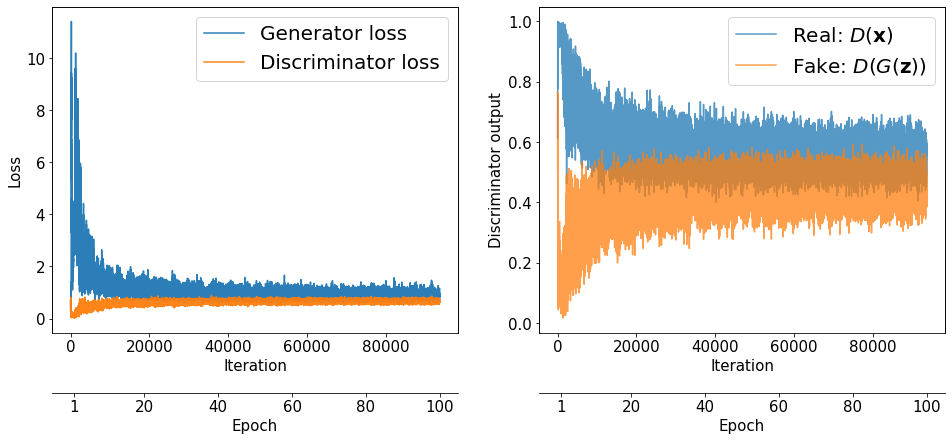

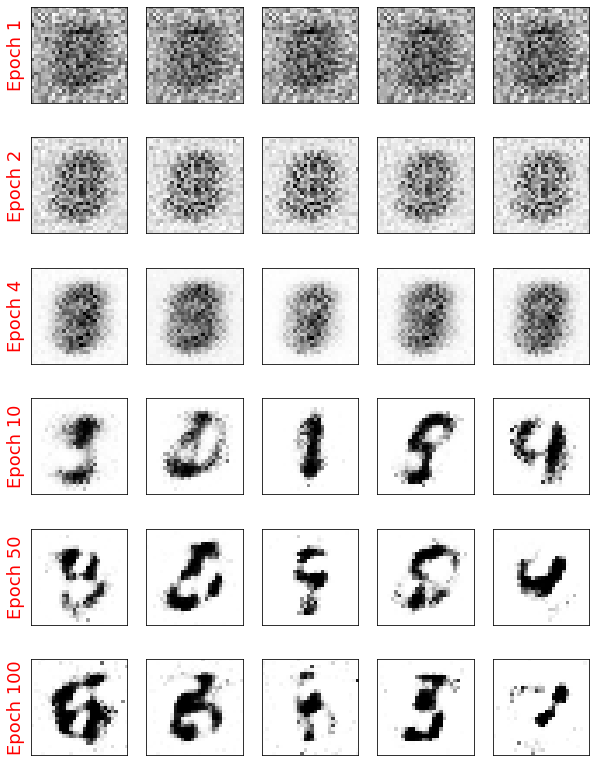

In [ ]:
import matplotlib.pyplot as plt
import itertools
import numpy as np

fig = plt.figure(figsize=(16, 6))

## Plotting the losses
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)


#plt.savefig('images/ch17-gan-learning-curve.pdf')
plt.show()




selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
#plt.savefig('images/ch17-vanila-gan-samples.pdf')
plt.show()


In [ ]:
##################################
# Deep Convolutional GAN (GCGAN) #
##################################

In [ ]:
#Create two helper functions to create the generator and discriminator networks

def make_dcgan_generator(
    z_size = 20, # z-vector of size 20 - input
    output_size = (28, 28, 1), # fake image size
    n_filters = 128, # filter size for the first tranposed convolution
    n_blocks = 2): 
  size_factor = 2 ** n_blocks
  hidden_size = (
      output_size[0]//size_factor,
      output_size[1]//size_factor)
  
  model = tf.keras.Sequential(
      [tf.keras.layers.Input(shape = (z_size,)),
       
       tf.keras.layers.Dense(
           units = n_filters * np.prod(hidden_size),
           use_bias = False), # important - bias unit not needed - already in BatchNorm
       
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.LeakyReLU(),
       tf.keras.layers.Reshape(
           (hidden_size[0], hidden_size[1], n_filters)), #creates the first 7, 7, 128 
       
       tf.keras.layers.Conv2DTranspose( # first transposed conv layer
           filters = n_filters, kernel_size = (5, 5),
           strides = (1,1), padding = 'same', use_bias = False),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.LeakyReLU()
       ])
  
  nf = n_filters
  for i in range(n_blocks): # creates two more t conv layers - spatial dimension increaseing but channels decrease
    nf = nf//2
    model.add(
        tf.keras.layers.Conv2DTranspose(
            filters = nf, kernel_size = (5,5),
            strides = (2,2), padding = 'same',
            use_bias = False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
  
  model.add( #creates final image that is 28, 28, 1 - input for disciminator
      tf.keras.layers.Conv2DTranspose(
          filters = output_size[2], kernel_size = (5, 5),
          strides = (1, 1), padding = 'same', use_bias = False,
          activation = 'tanh'))
  return model

In [ ]:
def make_dcgan_discriminator(
    input_size = (28, 28, 1),
    n_filters = 64,
    n_blocks = 2):
  model = tf.keras.Sequential(
      [tf.keras.layers.Input(shape = input_size),
       tf.keras.layers.Conv2D(
           filters = n_filters, kernel_size = 5,
           strides = (1, 1), padding = 'same'),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.LeakyReLU()
       ]) # creates 28 x 28 x 64 layer
  
  nf = n_filters
  for i in range(n_blocks): #two more layers
    nf = nf * 2 # doubles the channels but reduces dimension by half - stride (2x2)
    model.add(
        tf.keras.layers.Conv2D(
            filters = nf, kernel_size = (5, 5),
            strides = (2, 2), padding = 'same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
  
  model.add(
      tf.keras.layers.Conv2D(
          filters = 1, kernel_size = (7, 7),
          padding = 'valid'))
  
  model.add(
      tf.keras.layers.Reshape((1, )))
  
  return model

In [ ]:
import tensorflow_datasets as tfds

mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files = False)


def preprocess(ex, mode = 'uniform'):
  image = ex['image']
  image = tf.image.convert_image_dtype(image, tf.float32)

  image = image * 2 - 1.0
  if mode == 'uniform':
    input_z = tf.random.uniform(
        shape = (z_size,), minval = -1.0, maxval = 1.0)
  elif mode == 'normal':
    input_z = tf.random.normal(
        shape = (z_size,))
  return input_z, image #input_z is the import for the generator and image is the input for the discriminator 



In [ ]:
gen_model = make_dcgan_generator()
gen_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              125440    
_________________________________________________________________
batch_normalization_4 (Batch (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         409600    
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 128)        

In [ ]:
disc_model = make_dcgan_discriminator()
disc_model.summary() #BatchNorm parameters - mean and std are the non-trainable parameters

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)      

In [ ]:
#################################################
# Implimenting WGAN-GP to train the GCGAN model #
#################################################

#Essentially implimenting a different similiarity distance (earth-mover) with a gradient penalty 

In [ ]:
num_epochs = 100
batch_size = 128
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
lambda_gp = 10.0 # gradient penalty hyper-parameter

tf.random.set_seed(1)
np.random.seed(1)

# Set up the dataset
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)

mnist_trainset = mnist_trainset.shuffle(10000) 
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder = True)

## set-up the model
with tf.device(device_name):
  gen_model = make_dcgan_generator()
  gen_model.build(input_shape = (None, z_size))

  disc_model = make_dcgan_discriminator()
  disc_model.build(input_shape = (None, np.prod(image_size)))



In [ ]:
#We can now train the model with Adam optimizer for the WGAN-CP

import time

## Optimizers:
g_optimizer = tf.keras.optimizers.Adam(0.0002)
d_optimizer = tf.keras.optimizers.Adam(0.0002)

if mode_z == 'uniform':
  fixed_z = tf.random.uniform(
      shape = (batch_size, z_size), minval = -1, maxval = 1)
elif mode_z == 'normal':
  fixed_z = tf.random.normal(
      shape = (batch_size, z_size))
  
def create_samples(g_model, input_z):
  g_output = g_model(input_z, training = False)
  images = tf.reshape(g_output, (batch_size, *image_size))
  return (images + 1)/2.0

all_losses = []
epoch_samples = []
start_time = time.time()

for epoch in range(1, num_epochs + 1):
  epoch_losses = []

  for i, (input_z, input_real) in enumerate(mnist_trainset):
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
      
      g_output = gen_model(input_z, training = True)

      d_critics_real = disc_model(input_real, training = True)
      d_critics_fake = disc_model(g_output, training = True)

      ## Compute generator's loss:
      g_loss = -tf.math.reduce_mean(d_critics_fake)

      ## Compute discriminator's losses:
      d_loss_real = -tf.math.reduce_mean(d_critics_real)
      d_loss_fake = tf.math.reduce_mean(d_critics_fake)
      d_loss = d_loss_real + d_loss_fake

      #Gradient-penalty
      with tf.GradientTape() as gp_tape:
        alpha = tf.random.uniform(
            shape = [d_critics_real.shape[0], 1, 1, 1],
            minval = 0.0, maxval = 1.0)
        interpolated = (alpha * input_real + 
                        (1-alpha) * g_output)
        gp_tape.watch(interpolated)
        d_critics_intp = disc_model(interpolated)
      
      grads_intp = gp_tape.gradient(
          d_critics_intp, [interpolated,])[0]
      
      grads_intp_l2 = tf.sqrt(
          tf.reduce_sum(tf.square(grads_intp),
                        axis = [1, 2, 3]))
      
      grad_penalty = tf.reduce_mean(tf.square(
          grads_intp_l2 - 1.0))
      
      d_loss = d_loss + lambda_gp * grad_penalty

    #Optimization: Compute the gradients apply them
    d_grads = d_tape.gradient(d_loss,
                              disc_model.trainable_variables)
    d_optimizer.apply_gradients(
        grads_and_vars = zip(d_grads,
                             disc_model.trainable_variables))
    
    g_grads = g_tape.gradient(g_loss,
                              gen_model.trainable_variables)
    g_optimizer.apply_gradients(
        grads_and_vars = zip(g_grads,
                             gen_model.trainable_variables))
    
    epoch_losses.append((g_loss.numpy(), d_loss.numpy(),
                        d_loss_real.numpy(), d_loss_fake.numpy()))

  all_losses.append(epoch_losses)

  print('Epoch {:03d} | ET {:.2f} min | Avg Losses >>'
          ' G/D {:6.2f}/{:6.2f} [D-Real: {:6.2f}'
          ' D-Fake: {:6.2f}]'.format(
              epoch, (time.time() - start_time)/60,
              *list(np.mean(all_losses[-1], axis = 0))))
    
  epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy())
        



Epoch 001 | ET 3.71 min | Avg Losses >> G/D -411.59/-28.51 [D-Real: -537.38 D-Fake: 411.59]
Epoch 002 | ET 7.44 min | Avg Losses >> G/D -278.53/ 24.70 [D-Real: -360.36 D-Fake: 278.53]
Epoch 003 | ET 11.17 min | Avg Losses >> G/D -246.44/ -4.77 [D-Real: -281.30 D-Fake: 246.44]
Epoch 004 | ET 14.90 min | Avg Losses >> G/D -238.33/-29.30 [D-Real: -282.35 D-Fake: 238.33]
Epoch 005 | ET 18.63 min | Avg Losses >> G/D -244.90/-22.42 [D-Real: -278.44 D-Fake: 244.90]
Epoch 006 | ET 22.35 min | Avg Losses >> G/D -199.41/-28.66 [D-Real: -241.97 D-Fake: 199.41]
Epoch 007 | ET 26.08 min | Avg Losses >> G/D -250.95/-27.23 [D-Real: -290.92 D-Fake: 250.95]
Epoch 008 | ET 29.81 min | Avg Losses >> G/D -256.86/-17.78 [D-Real: -287.04 D-Fake: 256.86]
Epoch 009 | ET 33.54 min | Avg Losses >> G/D -258.78/-16.02 [D-Real: -285.28 D-Fake: 258.78]
Epoch 010 | ET 37.26 min | Avg Losses >> G/D -246.58/-22.23 [D-Real: -275.81 D-Fake: 246.58]
Epoch 011 | ET 40.97 min | Avg Losses >> G/D -262.00/-30.36 [D-Real: -30

In [ ]:
import pickle

pickle.dump({'all_losses': all_losses,
             'samples': epoch_samples},
            open('/content/drive/My Drive/Colab Notebooks/PyML/WDCGAN-learning.pkl', 'wb'))

gen_model.save('/content/drive/My Drive/Colab Notebooks/PyML/WDCGAN-gan_gen.h5')
disc_model.save('/content/drive/My Drive/Colab Notebooks/PyML/WDCGAN-gan_disc.h5')

In [ ]:
import pickle
wdcgan_learning = pickle.load(open('/content/drive/My Drive/Colab Notebooks/PyML/WDCGAN-learning.pkl', 'rb'))

In [ ]:
all_losses = wdcgan_learning['all_losses']
epoch_samples = wdcgan_learning['samples']

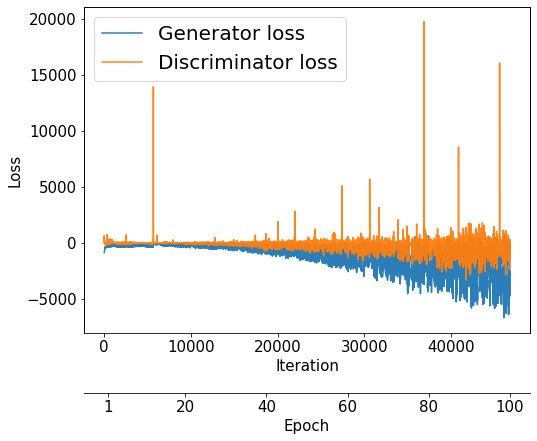

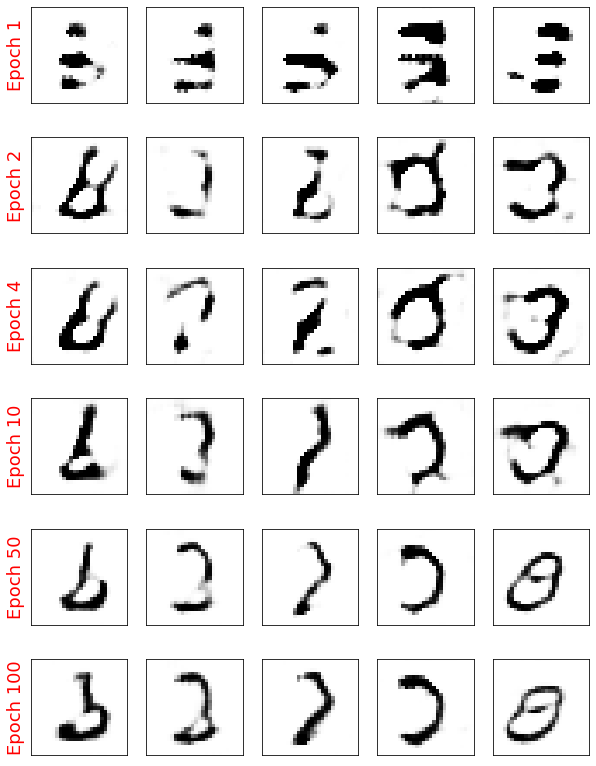

In [ ]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
fig = plt.figure(figsize=(8, 6))

## Plotting the losses
ax = fig.add_subplot(1, 1, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1] for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos   = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

#plt.savefig('images/ch17-wdcgan-learning-curve.pdf')
plt.show()




selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
